In [3]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import torch.nn.functional as F

#plotting
import matplotlib.pyplot as plt

import data_utils
import models
import importlib
import transformer_models
importlib.reload(data_utils)
importlib.reload(models)
importlib.reload(transformer_models)
from data_utils import *
from models import *
from transformer_models import * 
import torch.optim as optim
from torch.utils.data import DataLoader
import datetime
from tqdm import tqdm 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.Size([40, 80])
torch.Size([80, 40])
torch.Size([40, 80])
torch.Size([80, 40])
Using device: cpu


Import the dataloader objects. Don't worry too much about this 

In [4]:
data_dir = "data/"
dataObject = xrdData("data/", device)

dataObject.make_datasets(1, composition_embedding="compositionseq")
# Create DataLoaders for train and validation sets
train_loader = DataLoader(dataObject.torch_datasets['train'], batch_size=32, shuffle=True)
valid_loader = DataLoader(dataObject.torch_datasets['val'], batch_size=32, shuffle=False)  

Create the model. The model we're most interested in is the TransformerModel since it's our model but I also have a convolutional model implementated for reference / sanity checking.

In [ ]:
# Create the model instance and move it to the selected device
output_dim = 230  # Output dimension
ConvModel = XRD_C_SymNet(in_channels=1, output_dim=output_dim, composition_model= None).to(device)
token_size = 10 #dimension of the tokens 
TransModel = TransformerModel(ntoken = output_dim, d_model = token_size, nhead = 10, d_hid=50, nlayers=1, dropout = 0.5).to(device)
model = TransModel

# Define optimizer and loss function
weight_decay = 0  # Example value, adjust based on your needs
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

12160


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(ConvModel)

31369900

In [ ]:
count_parameters(TransModel)

31500410

In [ ]:
count_parameters(ConvModel) / count_parameters(TransModel)

0.995856879323158

This is a data augmenter that we will use to corrupt the diffraction pattern and simulate the effect of real experimental artifacts.
/

In [ ]:
#instantiate experimental data simulator 
simulator = ExperimentalSimulation(device, crop_start=500, crop_stop = 500, noise_range = 0.1, drop_width = 100, drop_freq = 2) 

NameError: name 'ExperimentalSimulation' is not defined

To demonstrate, I pulled a xrd from the train loader and implemented some simulated noise on it 

In [372]:
for xrd, composition, targets in train_loader:
    break

In [373]:
post_sim = simulator.sim(xrd)
post_norm = F.normalize(xrd, p=2, dim=1)

In [374]:
for_viz = xrd[1].detach().cpu().numpy()
post_sim_for_viz =  post_sim[1].detach().cpu().numpy()
post_norm_for_viz = post_norm[1].detach().cpu().numpy()

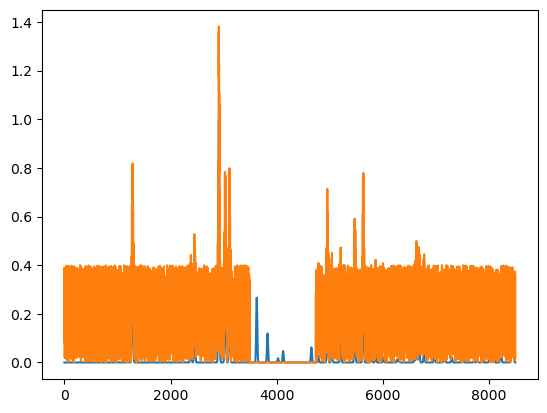

In [375]:
plt.plot(for_viz[0])
plt.plot(post_sim_for_viz[0])
# plt.plot(post_norm_for_viz[0])

In [376]:
max_epochs = 200
metrics = ["accuracy", "loss"]

log = {
    f"{type}": {f"{metric}" : np.zeros(max_epochs) for metric in metrics} for type in ['train', 'val']     
}

for epoch in range(max_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for xrd, composition, targets in tqdm(train_loader):
        xrd = simulator.sim(xrd)
        #xrd = F.normalize(xrd, p=2, dim=1)
        optimizer.zero_grad()
        outputs = model(xrd, composition)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = 100 * correct_train / total_train
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_valid_loss = 0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():  # No gradients needed for validation
        for xrd, composition, targets in tqdm(valid_loader):
            xrd = simulator.sim(xrd)
            #xrd = F.normalize(xrd, p=2, dim=1)
            outputs = model(xrd, composition)
            loss = criterion(outputs, targets)
            total_valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1) 
            total_valid += targets.size(0)
            correct_valid += (predicted == targets).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid

    total_train_loss = total_train_loss / len(train_loader)
    validation_loss = total_valid_loss / len(valid_loader)

    print(f"Epoch {epoch+1}, Training Loss: {total_train_loss}, Training Accuracy: {train_accuracy}%, Validation Loss: {validation_loss}, Validation Accuracy: {valid_accuracy}%")

    log['train']['accuracy'][epoch] = (train_accuracy)
    log['train']['loss'][epoch] =(total_train_loss)

    log['val']['accuracy'][epoch] =(valid_accuracy)
    log['val']['loss'][epoch] =(validation_loss)

100%|██████████| 121/121 [00:01<00:00, 114.98it/s]


Epoch 1, Training Loss: 3.5227233045651745, Training Accuracy: 20.666666666666668%, Validation Loss: 3.182519343273699, Validation Accuracy: 24.18436043500777%


100%|██████████| 121/121 [00:01<00:00, 108.62it/s]


Epoch 2, Training Loss: 3.0222551159973303, Training Accuracy: 28.0%, Validation Loss: 2.9276313545290105, Validation Accuracy: 29.88089073019161%


100%|██████████| 121/121 [00:01<00:00, 118.11it/s]


Epoch 3, Training Loss: 2.755541473097687, Training Accuracy: 33.21568627450981%, Validation Loss: 2.706550773510263, Validation Accuracy: 34.74883480062144%


100%|██████████| 121/121 [00:01<00:00, 118.16it/s]


Epoch 4, Training Loss: 2.6003367101137167, Training Accuracy: 36.254901960784316%, Validation Loss: 2.5919345666554348, Validation Accuracy: 36.89798032107716%


100%|██████████| 121/121 [00:01<00:00, 119.67it/s]


Epoch 5, Training Loss: 2.4757305920560033, Training Accuracy: 38.88562091503268%, Validation Loss: 2.499162099578164, Validation Accuracy: 38.91765924391507%


100%|██████████| 121/121 [00:01<00:00, 118.19it/s]


Epoch 6, Training Loss: 2.3717469551221955, Training Accuracy: 41.009803921568626%, Validation Loss: 2.46157728443461, Validation Accuracy: 39.84981874676333%


100%|██████████| 121/121 [00:01<00:00, 115.66it/s]


Epoch 7, Training Loss: 2.280034023267971, Training Accuracy: 42.470588235294116%, Validation Loss: 2.314775266923195, Validation Accuracy: 42.43915069911963%


100%|██████████| 121/121 [00:01<00:00, 119.88it/s]


Epoch 8, Training Loss: 2.20656321626721, Training Accuracy: 44.01307189542484%, Validation Loss: 2.275396962796361, Validation Accuracy: 43.319523562920764%


100%|██████████| 121/121 [00:01<00:00, 119.94it/s]


Epoch 9, Training Loss: 2.1288133707041528, Training Accuracy: 45.19934640522876%, Validation Loss: 2.234412133201095, Validation Accuracy: 44.19989642672191%


100%|██████████| 121/121 [00:01<00:00, 119.77it/s]


Epoch 10, Training Loss: 2.078550125987054, Training Accuracy: 46.35947712418301%, Validation Loss: 2.230698688956332, Validation Accuracy: 43.94096323148628%


100%|██████████| 121/121 [00:01<00:00, 119.27it/s]


Epoch 11, Training Loss: 2.0191717764426924, Training Accuracy: 47.990196078431374%, Validation Loss: 2.246142451428185, Validation Accuracy: 44.38114966338684%


100%|██████████| 121/121 [00:01<00:00, 119.57it/s]


Epoch 12, Training Loss: 1.9800486913419941, Training Accuracy: 48.85947712418301%, Validation Loss: 2.204015772204754, Validation Accuracy: 45.49456240290005%


100%|██████████| 121/121 [00:01<00:00, 119.78it/s]


Epoch 13, Training Loss: 1.9159194711856582, Training Accuracy: 49.869281045751634%, Validation Loss: 2.1997101444843388, Validation Accuracy: 46.064215432418436%


100%|██████████| 121/121 [00:01<00:00, 119.86it/s]


Epoch 14, Training Loss: 1.8779901659725353, Training Accuracy: 50.85294117647059%, Validation Loss: 2.13176292131755, Validation Accuracy: 46.349041947177625%


100%|██████████| 121/121 [00:01<00:00, 119.82it/s]


Epoch 15, Training Loss: 1.8290465919450782, Training Accuracy: 51.790849673202615%, Validation Loss: 2.095800815534986, Validation Accuracy: 47.77317452097359%


100%|██████████| 121/121 [00:01<00:00, 119.32it/s]


Epoch 16, Training Loss: 1.7906471123391434, Training Accuracy: 52.35947712418301%, Validation Loss: 2.085598208687522, Validation Accuracy: 47.540134645261524%


100%|██████████| 121/121 [00:01<00:00, 116.97it/s]


Epoch 17, Training Loss: 1.7606816775123653, Training Accuracy: 53.10457516339869%, Validation Loss: 2.092470873485912, Validation Accuracy: 49.041947177628174%


100%|██████████| 121/121 [00:01<00:00, 119.35it/s]


Epoch 18, Training Loss: 1.7031152461389762, Training Accuracy: 54.22222222222222%, Validation Loss: 2.112648442757031, Validation Accuracy: 47.928534438114966%


 15%|█▌        | 144/957 [00:03<00:18, 43.19it/s]


KeyboardInterrupt: 

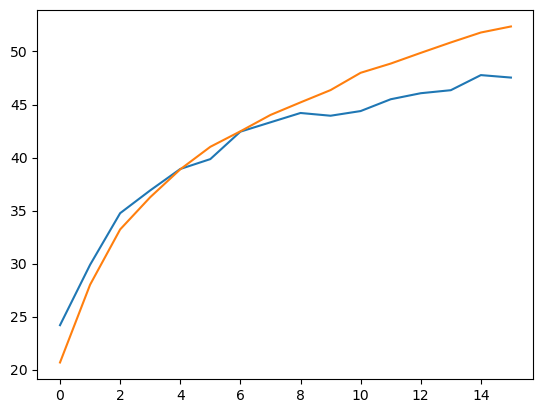

In [377]:
plt.plot(log['val']['accuracy'][:16])
plt.plot(log['train']['accuracy'][:16])

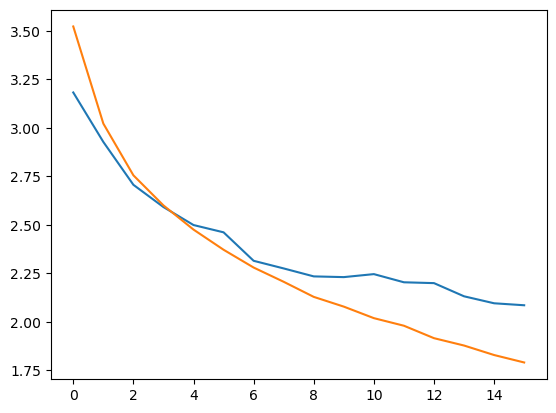

In [378]:
plt.plot(log['val']['loss'][:16])
plt.plot(log['train']['loss'][:16])

In [ ]:
model_dir = "models/"

date = datetime.now()
model_name = f"first_model_{date.month}_{date.day}"

os.makedirs(os.path.join(model_dir, model_name), exist_ok=True)

torch.save(model, os.path.join(model_dir, model_name, 'model.pth'))

for data_type, metrics_dict in log.items():
    for metric, array in metrics_dict.items():
        filename = f"{data_type}_{metric}.npy"  # Construct filename, e.g., "train_accuracy.npy"
        filename = os.path.join(model_dir, model_name, filename)
        np.save(filename, array)  # Save the array to a file

AttributeError: module 'datetime' has no attribute 'now'